# 手工实现三层神经网络分类器

本项目实现了一个从零开始手工实现的三层神经网络分类器，用于CIFAR-10图像分类任务。

该项目不依赖深度学习框架，而是通过NumPy手动实现了神经网络的前向传播、反向传播、各种激活函数、损失函数和优化器等核心组件。

## 1. 项目概述

本项目实现了一个完整的三层神经网络分类器，包括：

- **模型架构**：输入层 → 隐藏层1 → 隐藏层2 → 输出层
- **激活函数**：支持多种激活函数（Sigmoid、ReLU、Tanh、Softmax）
- **损失函数**：交叉熵损失函数
- **优化器**：SGD优化器（支持动量和L2正则化）
- **学习率调度**：支持学习率衰减策略
- **超参数搜索**：支持调节学习率、隐藏层大小、正则化强度等超参数

项目的主要目标是通过手动实现神经网络的各个组件，深入理解神经网络的工作原理和训练过程。

## 2. 导入必要的库

导入项目所需的库和模块。

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

from model import ThreeLayerNet
from losses import get_loss
from optimizer import get_optimizer, get_scheduler
from train import train_model
from evaluation import load_and_test, evaluate_model_classes
from hyperparameter_search import HyperparameterSearch, example_grid_search, example_random_search
from utils import download_cifar10, load_cifar10, preprocess_data, visualize_sample, plot_training_history
from config import DEFAULT_CONFIG, SEARCH_CONFIG, CIFAR10_CLASSES

## 3. 配置参数

定义运行模式和各种参数。在main.py中，这些参数是通过命令行参数解析获取的，但在Jupyter笔记本中，可以直接设置这些参数。

In [2]:
# 数据参数
data_dir = 'data'
download = False  # 是否下载CIFAR-10数据集

# 模型参数
hidden_size1 = DEFAULT_CONFIG['hidden_size1']  # 第一隐藏层大小
hidden_size2 = DEFAULT_CONFIG['hidden_size2']  # 第二隐藏层大小
hidden_activation = DEFAULT_CONFIG['hidden_activation']  # 隐藏层激活函数

# 训练参数
learning_rate = DEFAULT_CONFIG['learning_rate']  # 学习率
momentum = DEFAULT_CONFIG['momentum']  # 动量系数
weight_decay = DEFAULT_CONFIG['weight_decay']  # L2正则化系数
batch_size = DEFAULT_CONFIG['batch_size']  # 批量大小
epochs = DEFAULT_CONFIG['epochs']  # 训练轮数

# 学习率调度参数
scheduler = DEFAULT_CONFIG['scheduler']  # 学习率调度器类型

# 路径参数
model_dir = DEFAULT_CONFIG['model_dir']  # 模型保存目录
model_path = None  # 模型路径（用于测试模式）
results_dir = DEFAULT_CONFIG['results_dir']  # 结果保存目录

# 超参数搜索参数
search_type = 'grid'  # 超参数搜索类型：'grid'或'random'
search_epochs = 10  # 超参数搜索中每个配置的训练轮数

## 4. 创建必要的目录

确保数据、模型和结果的目录存在。

In [3]:
# 创建必要的目录
os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## 5. 下载和加载CIFAR-10数据集

CIFAR-10是一个包含10个类别的图像分类数据集，每个类别有6000张32x32的彩色图像。我们将下载（如果需要）并加载这个数据集。

In [4]:
# 下载或加载CIFAR-10数据集
cifar10_dir = os.path.join(data_dir, 'cifar-10-batches-py')
if download or not os.path.exists(cifar10_dir):
    cifar10_dir = download_cifar10(data_dir)

# 加载数据集
try:
    X_train, y_train, X_test, y_test = load_cifar10(cifar10_dir)
    print(f"加载CIFAR-10数据集成功！训练集: {X_train.shape}, 测试集: {X_test.shape}")
except Exception as e:
    print(f"加载CIFAR-10数据集失败: {e}")
    print("请确保数据集已下载，或设置download=True下载数据集")
    raise

加载CIFAR-10数据集成功！训练集: (50000, 3072), 测试集: (10000, 3072)


## 6. 数据预处理

对数据进行预处理，包括：
1. 将像素值归一化到[0, 1]范围
2. 标准化（零均值，单位方差）
3. 分割训练集和验证集

In [5]:
# 预处理数据
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(
    X_train, y_train, X_test, y_test, validation_split=DEFAULT_CONFIG['validation_split']
)
print(f"数据预处理完成！训练集: {X_train.shape}, 验证集: {X_val.shape}, 测试集: {X_test.shape}")

数据预处理完成！训练集: (45000, 3072), 验证集: (5000, 3072), 测试集: (10000, 3072)


## 7. 模型训练

训练一个三层神经网络模型。


开始训练模型...
Epoch 1/25 - 保存最佳模型，验证准确率: 0.3714
Epoch 1/25 - 耗时: 9.14s - 学习率: 0.200000
  训练损失: 1.9800 - 训练准确率: 0.3082
  验证损失: 1.7884 - 验证准确率: 0.3714
Epoch 2/25 - 保存最佳模型，验证准确率: 0.4094
Epoch 2/25 - 耗时: 9.10s - 学习率: 0.196000
  训练损失: 1.6871 - 训练准确率: 0.4106
  验证损失: 1.6818 - 验证准确率: 0.4094
Epoch 3/25 - 保存最佳模型，验证准确率: 0.4250
Epoch 3/25 - 耗时: 9.02s - 学习率: 0.192080
  训练损失: 1.5980 - 训练准确率: 0.4471
  验证损失: 1.6332 - 验证准确率: 0.4250
Epoch 4/25 - 保存最佳模型，验证准确率: 0.4364
Epoch 4/25 - 耗时: 9.10s - 学习率: 0.188238
  训练损失: 1.5446 - 训练准确率: 0.4686
  验证损失: 1.6037 - 验证准确率: 0.4364
Epoch 5/25 - 保存最佳模型，验证准确率: 0.4439
Epoch 5/25 - 耗时: 8.96s - 学习率: 0.184474
  训练损失: 1.5086 - 训练准确率: 0.4832
  验证损失: 1.5788 - 验证准确率: 0.4439
Epoch 6/25 - 保存最佳模型，验证准确率: 0.4510
Epoch 6/25 - 耗时: 9.17s - 学习率: 0.180784
  训练损失: 1.4818 - 训练准确率: 0.4934
  验证损失: 1.5606 - 验证准确率: 0.4510
Epoch 7/25 - 保存最佳模型，验证准确率: 0.4642
Epoch 7/25 - 耗时: 9.09s - 学习率: 0.177168
  训练损失: 1.4608 - 训练准确率: 0.5031
  验证损失: 1.5477 - 验证准确率: 0.4642
Epoch 8/25 - 耗时: 8.98s - 学习率: 0.173625
  训练损

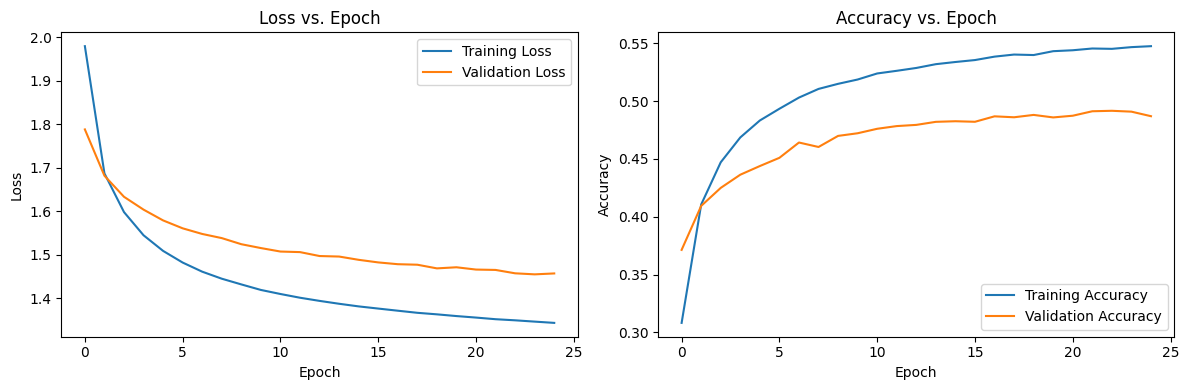


在测试集上评估模型...
测试集准确率: 0.5057
各类别准确率:
  airplane: 0.5590
  automobile: 0.6230
  bird: 0.3460
  cat: 0.3160
  deer: 0.3690
  dog: 0.3970
  frog: 0.5740
  horse: 0.6120
  ship: 0.6860
  truck: 0.5750


{'airplane': np.float64(0.559),
 'automobile': np.float64(0.623),
 'bird': np.float64(0.346),
 'cat': np.float64(0.316),
 'deer': np.float64(0.369),
 'dog': np.float64(0.397),
 'frog': np.float64(0.574),
 'horse': np.float64(0.612),
 'ship': np.float64(0.686),
 'truck': np.float64(0.575)}

In [6]:
print("\n开始训练模型...")

# 构建训练配置
train_config = {
    'input_size': X_train.shape[1],
    'hidden_size1': hidden_size1,
    'hidden_size2': hidden_size2,
    'output_size': len(CIFAR10_CLASSES),
    'hidden_activation': hidden_activation,
    'output_activation': 'softmax',
    'loss': 'cross_entropy',
    'optimizer': 'sgd',
    'learning_rate': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
    'scheduler': scheduler,
    'scheduler_params': DEFAULT_CONFIG['scheduler_params'],
    'batch_size': batch_size,
    'epochs': epochs,
    'model_dir': model_dir,
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

# 训练模型
model, history = train_model(train_config)

# 绘制训练历史
plot_training_history(history)

# 在测试集上评估
print("\n在测试集上评估模型...")
test_acc = load_and_test(
    os.path.join(model_dir, 'best_model.npz'),
    X_test, y_test,
    model_config={
        'input_size': X_train.shape[1],
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'output_size': len(CIFAR10_CLASSES),
        'hidden_activation': hidden_activation,
        'output_activation': 'softmax'
    }
)

# 评估各类别性能
evaluate_model_classes(model, X_test, y_test, CIFAR10_CLASSES)

## 8. 模型测试

加载预训练的模型并在测试集上评估其性能。

In [7]:
print("\n开始测试模型...")

# 检查模型路径
if model_path is None:
    model_path = os.path.join(model_dir, 'best_model.npz')

if not os.path.exists(model_path):
    print(f"模型文件不存在: {model_path}")
    raise FileNotFoundError(f"模型文件不存在: {model_path}")

# 加载并测试模型
test_acc = load_and_test(
    model_path,
    X_test, y_test,
    model_config={
        'input_size': X_train.shape[1],
        'hidden_size1': hidden_size1,
        'hidden_size2': hidden_size2,
        'output_size': len(CIFAR10_CLASSES),
        'hidden_activation': hidden_activation,
        'output_activation': 'softmax'
    }
)

# 创建模型实例用于评估各类别性能
model = ThreeLayerNet(
    input_size=X_train.shape[1],
    hidden_size1=hidden_size1,
    hidden_size2=hidden_size2,
    output_size=len(CIFAR10_CLASSES),
    hidden_activation=hidden_activation,
    output_activation='softmax'
)
model.load_model(model_path)

# 评估各类别性能
evaluate_model_classes(model, X_test, y_test, CIFAR10_CLASSES)


开始测试模型...
测试集准确率: 0.5057
各类别准确率:
  airplane: 0.5590
  automobile: 0.6230
  bird: 0.3460
  cat: 0.3160
  deer: 0.3690
  dog: 0.3970
  frog: 0.5740
  horse: 0.6120
  ship: 0.6860
  truck: 0.5750


{'airplane': np.float64(0.559),
 'automobile': np.float64(0.623),
 'bird': np.float64(0.346),
 'cat': np.float64(0.316),
 'deer': np.float64(0.369),
 'dog': np.float64(0.397),
 'frog': np.float64(0.574),
 'horse': np.float64(0.612),
 'ship': np.float64(0.686),
 'truck': np.float64(0.575)}

## 9. 超参数搜索

执行超参数搜索，寻找最佳的模型配置。

搜索空间见config.py

In [8]:
print("\n开始超参数搜索...")

if search_type == 'grid':
    # 网格搜索
    print("执行网格搜索...")
    best_config, results = example_grid_search(
        X_train, y_train, X_val, y_val, X_test, y_test
    )
else:
    # 随机搜索
    print("执行随机搜索...")
    best_config, results = example_random_search(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

# 打印最佳配置
print("\n超参数搜索完成！")
print("最佳配置:")
for name, value in best_config.items():
    print(f"  {name}: {value}")


开始超参数搜索...
执行网格搜索...
总共需要搜索 324 种超参数组合

搜索进度: [1/324]
当前配置:
  hidden_size1: 128
  hidden_size2: 64
  hidden_activation: relu
  learning_rate: 0.1
  momentum: 0.0
  weight_decay: 0.0
  input_size: 3072
  output_size: 10
  output_activation: softmax
  loss: cross_entropy
Epoch 1/10 - 保存最佳模型，验证准确率: 0.2553
Epoch 1/10 - 耗时: 3.74s - 学习率: 0.100000
  训练损失: 2.3429 - 训练准确率: 0.2107
  验证损失: 2.1162 - 验证准确率: 0.2553
Epoch 2/10 - 保存最佳模型，验证准确率: 0.3002
Epoch 2/10 - 耗时: 3.60s - 学习率: 0.100000
  训练损失: 2.0109 - 训练准确率: 0.2976
  验证损失: 1.9800 - 验证准确率: 0.3002
Epoch 3/10 - 保存最佳模型，验证准确率: 0.3248
Epoch 3/10 - 耗时: 3.70s - 学习率: 0.100000
  训练损失: 1.9106 - 训练准确率: 0.3362
  验证损失: 1.9054 - 验证准确率: 0.3248
Epoch 4/10 - 保存最佳模型，验证准确率: 0.3467
Epoch 4/10 - 耗时: 3.59s - 学习率: 0.100000
  训练损失: 1.8484 - 训练准确率: 0.3592
  验证损失: 1.8563 - 验证准确率: 0.3467
Epoch 5/10 - 保存最佳模型，验证准确率: 0.3637
Epoch 5/10 - 耗时: 3.62s - 学习率: 0.100000
  训练损失: 1.8035 - 训练准确率: 0.3752
  验证损失: 1.8184 - 验证准确率: 0.3637
Epoch 6/10 - 保存最佳模型，验证准确率: 0.3656
Epoch 6/10 - 耗时: 3.8

OSError: [Errno 22] Invalid argument: 'search_results\\models\\best_model.npz'

## 10. 数据可视化

## 可视化超参数搜索结果

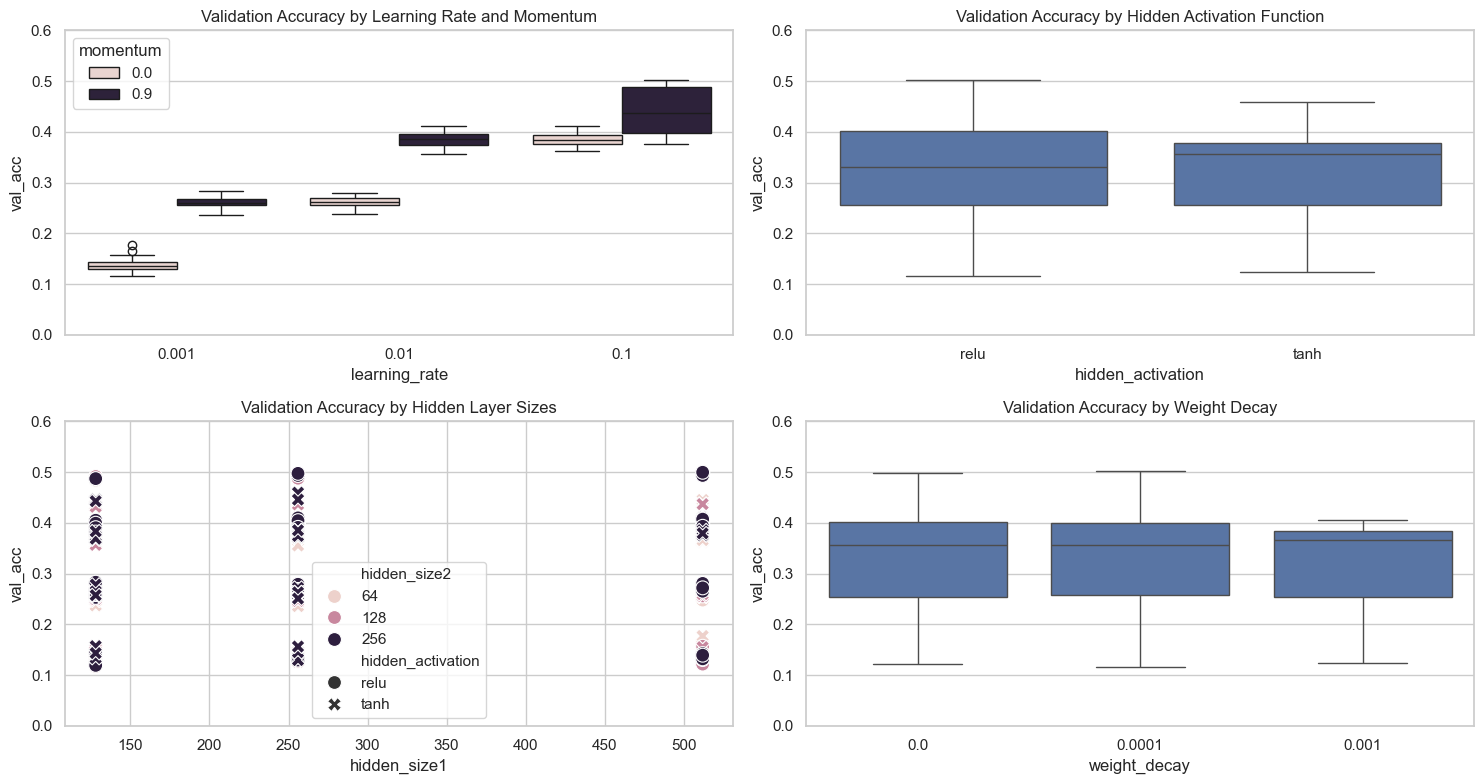


Best Configuration:
Validation Accuracy: 0.5014
Test Accuracy: 0.5068
Hidden Sizes: 512, 64
Activation: relu
Learning Rate: 0.1
Momentum: 0.9
Weight Decay: 0.0001


In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载JSON数据
with open('d:/Vscode/Project/ML/NN by hand/search_results/search_results.json', 'r') as f:
    data = json.load(f)

# 将数据转换为DataFrame
results = []
for result in data['results']:
    config = result['config']
    row = {
        'hidden_size1': config['hidden_size1'],
        'hidden_size2': config['hidden_size2'],
        'hidden_activation': config['hidden_activation'],
        'learning_rate': config['learning_rate'],
        'momentum': config['momentum'],
        'weight_decay': config['weight_decay'],
        'val_acc': result['val_acc'],
        'test_acc': result['test_acc'],
        'training_time': result['training_time']
    }
    results.append(row)
    
df = pd.DataFrame(results)

# 设置绘图风格
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# 1. 不同学习率和动量对验证准确率的影响
plt.subplot(2, 2, 1)
sns.boxplot(x='learning_rate', y='val_acc', hue='momentum', data=df)
plt.title('Validation Accuracy by Learning Rate and Momentum')
plt.ylim(0, 0.6)

# 2. 不同隐藏层激活函数对准确率的影响
plt.subplot(2, 2, 2)
sns.boxplot(x='hidden_activation', y='val_acc', data=df)
plt.title('Validation Accuracy by Hidden Activation Function')
plt.ylim(0, 0.6)

# 3. 不同隐藏层大小对准确率的影响
plt.subplot(2, 2, 3)
sns.scatterplot(x='hidden_size1', y='val_acc', hue='hidden_size2', style='hidden_activation', data=df, s=100)
plt.title('Validation Accuracy by Hidden Layer Sizes')
plt.ylim(0, 0.6)

# 4. 权重衰减对准确率的影响
plt.subplot(2, 2, 4)
sns.boxplot(x='weight_decay', y='val_acc', data=df)
plt.title('Validation Accuracy by Weight Decay')
plt.ylim(0, 0.6)

plt.tight_layout()
plt.show()

# 最佳配置分析
best_config = df.loc[df['val_acc'].idxmax()]
print("\nBest Configuration:")
print(f"Validation Accuracy: {best_config['val_acc']:.4f}")
print(f"Test Accuracy: {best_config['test_acc']:.4f}")
print(f"Hidden Sizes: {best_config['hidden_size1']}, {best_config['hidden_size2']}")
print(f"Activation: {best_config['hidden_activation']}")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Momentum: {best_config['momentum']}")
print(f"Weight Decay: {best_config['weight_decay']}")

## 可视化CIFAR-10数据集的样本。


可视化CIFAR-10样本...


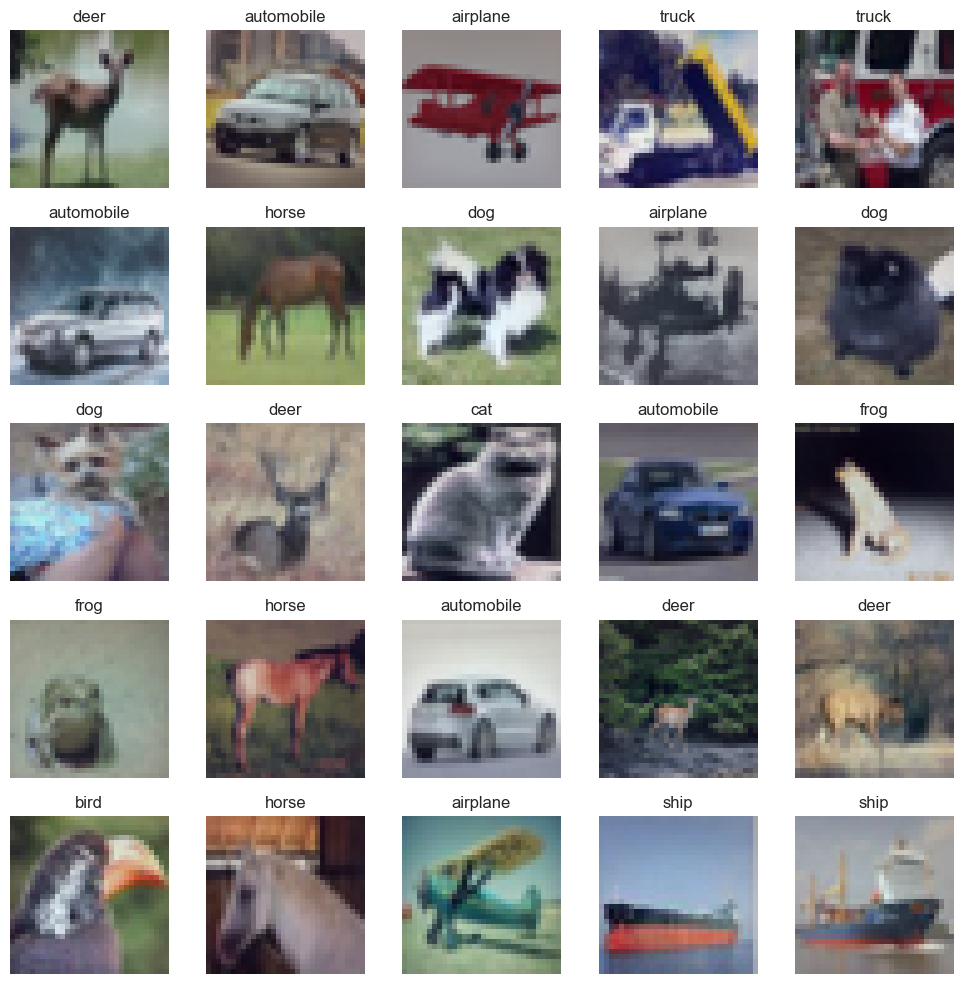

In [10]:
# 可视化模式
print("\n可视化CIFAR-10样本...")

# 随机选择一些样本进行可视化
indices = np.random.choice(len(X_test), 25, replace=False)
visualize_sample(X_test[indices], y_test[indices], CIFAR10_CLASSES)

## 11. 自定义运行

可以根据需要自定义运行代码，例如尝试不同的超参数组合、可视化特定样本等。

In [ ]:
# 自定义代码示例
# 例如：可视化一些样本
# indices = np.random.choice(len(X_test), 25, replace=False)
# visualize_sample(X_test[indices], y_test[indices], CIFAR10_CLASSES)

# 例如：尝试不同的超参数
# custom_config = {
#     'input_size': X_train.shape[1],
#     'hidden_size1': 1024,  # 更大的隐藏层
#     'hidden_size2': 512,
#     'output_size': len(CIFAR10_CLASSES),
#     'hidden_activation': 'tanh',  # 不同的激活函数
#     'output_activation': 'softmax',
#     'loss': 'cross_entropy',
#     'optimizer': 'sgd',
#     'learning_rate': 0.005,
#     'momentum': 0.95,
#     'weight_decay': 0.0005,
#     'scheduler': 'step',
#     'scheduler_params': {'step_size': 5, 'gamma': 0.5},
#     'batch_size': 64,
#     'epochs': 20,
#     'model_dir': 'models/custom',
#     'X_train': X_train,
#     'y_train': y_train,
#     'X_val': X_val,
#     'y_val': y_val
# }
# os.makedirs('models/custom', exist_ok=True)
# custom_model, custom_history = train_model(custom_config)
# plot_training_history(custom_history)

## 12. 总结

这个项目实现了一个手工构建的三层神经网络分类器，用于CIFAR-10图像分类任务。展示了如何：

1. 加载和预处理CIFAR-10数据集
2. 构建和训练三层神经网络模型
3. 评估模型在测试集上的性能
4. 执行超参数搜索以找到最佳模型配置
5. 可视化数据集样本